In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

import os
from vis_tool import walk_through

In [3]:
sns.set_style("whitegrid", {"grid.linestyle": "--"})
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 13  # 10
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.offset_threshold"] = 1
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Liberation Serif"]
plt.rcParams["text.usetex"] = True

l2 = r"$\ell_2$"  # latex

# Part 1: Individual Task

In [ ]:
# plt.rcParams["axes.titlesize"] = 11  # for distractors

x_label = "environment steps"
metric, y_label, sci_axis = "return", "episode return", "both"
# metric, y_label, sci_axis = "rank-2", "matrix rank", "x" # default is rank-2
# metric, y_label, sci_axis = "l2", "ZP loss", "x"
# metric, y_label, sci_axis = "fkl", "ZP loss", "x"
# metric, y_label, sci_axis = "rkl", "ZP loss", "x"
separate_legend = (
    True
    # False
)
tag = (
    ""
    # "l2"
    # "fkl"
    # "rkl"
    # "ablate-"
)

hue = (
    "aux"
    # "aux_optim"
    # "aux_coef"
)
style = (
    None
    # "aux"
    # "aux_optim"
    # "aux_coef"
)


def reduce_algo_to_aux(algo, aux):
    if algo == "alm-3":
        return "ALM(3)"
    elif algo == "alm-no-model-1":
        return "ALM-no-model"
    elif algo == "alm-no-model":
        return "ALM(0)"
    aux_renames = {
        "None": "TD3",
        "l2": "ZP-" + l2 + " (ours)",
        "rkl": "ZP-RKL (ours)",
        "fkl": "ZP-FKL (ours)",
        "op-l2": "OP-" + l2,
        "op-kl": "OP-FKL",
    }
    return aux_renames[aux]


def rename_optim(optim):
    optim_names = {
        "online": "Online",
        "detach": "Detached",
        "ema": "EMA",
    }
    if optim in optim_names:
        return optim_names[optim]
    else:
        return optim


def query_fn(flags):
    if "ours" in flags["algo"]:
        ## ablation
        if tag == "ablate-":  # ALM variants
            return (
                flags["aux"] == "rkl"
                and flags["aux_coef"] == "v-1.0"
                and flags["aux_optim"] == "ema"
                and flags["lr"]["model"] == 0.0001
            )
        elif tag == "":
            if flags["aux"] == "l2":
                return (
                    flags["aux_optim"] == "ema"
                    and flags["aux_coef"] == "v-10.0"
                    and flags["lr"]["model"] == 0.0001
                )
            elif flags["aux"] in ["rkl", "fkl"]:
                return (
                    flags["aux_optim"] == "ema"
                    and flags["aux_coef"] == "v-1.0"
                    and flags["lr"]["model"] == 0.0001
                )
            return True
        elif tag in ["l2", "rkl", "fkl"]:
            if tag == "l2":
                return (
                    flags["aux"] == tag
                    and flags["aux_coef"] == "v-10.0"
                    and flags["lr"]["model"] == 0.0001
                )
            else:
                return (
                    flags["aux"] == tag
                    and flags["aux_coef"] == "v-1.0"
                    and flags["lr"]["model"] == 0.0001
                )
    #### choose one of the following lines
    # return False
    # return flags["algo"] == "alm-3"
    # return flags["algo"] in ["alm-3", "alm-no-model", "alm-no-model-1"] # some ablation


for env, distraction in product(
    [
        "Ant-v2",
        "HalfCheetah-v2",
        "Hopper-v2",
        "Humanoid-v2",
        "Walker2d-v2",
    ],
    [
        0,
        # 2**4,
        # 2**5,
        # 2**6,
        # 2**7,
        # 2**8,
    ],
):
    if distraction > 0:
        end = 1.5e6
        env_tag = env + f"-d{distraction}"
    else:
        end = 0.5e6  # 1.5e6 #
        env_tag = env
    path = "logs/" + env_tag

    df = walk_through(
        path,
        metric,
        query_fn,
        start=0,
        end=end,
        steps=100,
        window=3,
    )
    df = df.fillna(False)

    # custom functions to reduce or rename flags
    df[x_label] = df["env_steps"]
    df["aux"] = df.apply(
        lambda row: reduce_algo_to_aux(row["algo"], row["aux"]), axis=1
    )
    df["aux_optim"] = df.apply(lambda row: rename_optim(row["aux_optim"]), axis=1)
    if metric in df:
        df[y_label] = df[metric]

    # print stats of runs
    if style is None or style == hue:
        print(df.drop_duplicates(subset=["logdir"]).groupby([hue]).size())
    else:
        print(df.drop_duplicates(subset=["logdir"]).groupby([hue, style]).size())

    ans = sns.lineplot(
        data=df,
        x=x_label,
        y=y_label,
        palette="Dark2",
        hue=hue,
        hue_order=np.sort(df[hue].unique()) if hue is not None else None,
        style=style,
        style_order=np.sort(df[style].unique()) if style is not None else None,
    )
    if "l2" in metric or "kl" in metric or "cond" in metric:
        ans.set_yscale("log")

    if separate_legend:
        ans.legend().set_visible(False)
    else:
        ans.legend(framealpha=0.2)  # must use the returned ans

    plt.xlim(0, end)
    plt.ticklabel_format(
        axis=sci_axis, style="sci", scilimits=(0, 0)
    )  # default [-5, 6]
    plt.title(env if distraction == 0 else env + f" w/ {distraction} distractors")

    os.makedirs(
        "plts", exist_ok=True
    )  # use flattened folder for easy upload in overleaf
    plt.savefig(
        f"plts/{tag}{env_tag}_{metric}_{hue}_{style}"
        + ("" if separate_legend else "_leg")
        + ".pdf",
        bbox_inches="tight",
        pad_inches=0.03,
    )  # default 0.1
    plt.show()
    plt.close()

In [ ]:
if separate_legend:
    # draw a separate legend figure
    legend_fig, legend_ax = plt.subplots(figsize=(4, 0.1))  # match figsize?
    legend_squared = legend_ax.legend(
        *ans.get_legend_handles_labels(),
        bbox_to_anchor=(0, 0, 2.2, 1),  # x0, y0, width, height
        bbox_transform=legend_fig.transFigure,
        frameon=True,  # controls the border
        fancybox=None,
        shadow=False,
        ncol=len(ans.get_legend_handles_labels()[-1]),  # num of labels
        mode="expand",
    )
    legend_ax.axis("off")
    plt.savefig(
        f"plts/{tag}"
        + ("standard" if distraction == 0 else "distracted")
        + f"-legend_{metric}_{hue}_{style}.pdf",
        bbox_inches="tight",
        pad_inches=0.03,
    )
    plt.show()
    plt.close()

# Part 2: Aggregation Plot

In [ ]:
plt.rcParams["axes.titlesize"] = 12
x_label = "environment steps"
metric, y_label, sci_axis = "return", "episode return", "y"
# metric, y_label, sci_axis = "rank-2", "matrix rank", "x" # default is rank-2
separate_legend = True
x_axis = "Number of distractors"

hue = (
    # "algo"
    # "aux_optim"
    "aux"
    # "aux_coef"
    # "lr.model"
)
style = hue


def reduce_algo_to_aux(algo, aux):
    if algo == "alm-3":
        return "ALM(3)"
    l2 = r"$\ell_2$"  # latex
    aux_renames = {
        "None": "TD3",
        "l2": "ZP-" + l2 + " (ours)",
        "rkl": "ZP-RKL (ours)",
        "fkl": "ZP-FKL (ours)",
        "op-l2": "OP-" + l2,
        "op-kl": "OP-FKL",
    }
    return aux_renames[aux]


def rename_optim(optim):
    optim_names = {
        "online": "Online",
        "detach": "Detached",
        "ema": "EMA",
    }
    if optim in optim_names:
        return optim_names[optim]
    else:
        return optim


def query_fn(flags):
    if "ours" in flags["algo"]:
        # return flags["aux"] == "l2" and flags["aux_coef"] == "v-10.0" and flags["lr"]["model"] == 0.0001
        if flags["aux"] == "l2":
            return (
                flags["aux_optim"] == "ema"
                and flags["aux_coef"] == "v-10.0"
                and flags["lr"]["model"] == 0.0001
            )
        elif flags["aux"] in ["rkl", "fkl"]:
            return (
                flags["aux_optim"] == "ema"
                and flags["aux_coef"] == "v-1.0"
                and flags["lr"]["model"] == 0.0001
            )
        return True
        # if flags["aux_optim"] in ["ema", "detach", "online"] and flags["lr"]["model"] == 0.0001:
        #     if flags["aux"] == "l2":
        #         return flags["aux_coef"] == "v-10.0"
        #     else:
        #         return flags["aux_coef"] == "v-1.0"
        # return False
    return False
    # return flags["algo"] == "alm-3"


for env in [
    "Ant-v2",
    "HalfCheetah-v2",
    "Hopper-v2",
    "Walker2d-v2",
]:
    end = 1.5e6
    dfs = []

    for distraction in [
        0,
        2**4,
        2**5,
        2**6,
        2**7,
        2**8,
    ]:
        if distraction > 0:
            env_tag = env + f"-d{distraction}"
        else:
            env_tag = env

        path = "logs/" + env_tag

        df = walk_through(
            path,
            metric,
            query_fn,
            start=0,
            end=end,
            steps=100,
            window=3,
        )
        df = df.fillna(False)

        # custom functions to reduce or rename flags
        df[x_label] = df["env_steps"]
        df["aux"] = df.apply(
            lambda row: reduce_algo_to_aux(row["algo"], row["aux"]), axis=1
        )
        df["aux_optim"] = df.apply(lambda row: rename_optim(row["aux_optim"]), axis=1)
        if metric in df:
            df[y_label] = df[metric]

        final_values = df.loc[df[x_label] == df[x_label].max()]
        final_values[x_axis] = max(distraction, 1)  # NOTE: clip
        dfs.append(final_values)

    df = pd.concat(dfs, axis=0, ignore_index=True)

    ans = sns.lineplot(
        data=df,
        x=x_axis,
        y=y_label,
        palette="Dark2",
        hue=hue,
        hue_order=np.sort(df[hue].unique()) if hue is not None else None,
        style=style,
        style_order=np.sort(df[style].unique()) if style is not None else None,
        markers=True,
        dashes=False,
        markersize=10,
        markeredgewidth=0,
        # the reviewer finds that the plot has marker edge, while the legend does not.
        # This is seaborn's behavior, and I cannot change it, so I have to disable marker edges in plots.
        alpha=0.9,
    )
    ans.set_xscale("log", base=2)  # NOTE:
    if "l2" in metric or "kl" in metric or "cond" in metric:
        ans.set_yscale("log")

    if separate_legend:
        ans.legend().set_visible(False)
    else:
        ans.legend(framealpha=0.2)  # must use the returned ans

    plt.ticklabel_format(
        axis=sci_axis, style="sci", scilimits=(0, 0)
    )  # default [-5, 6]
    plt.title(env + " with distractors")

    os.makedirs(
        "plts", exist_ok=True
    )  # use flattened folder for easy upload in overleaf
    plt.savefig(
        f"plts/distract-{env}_{metric}_{hue}_{style}"
        + ("" if separate_legend else "_leg")
        + ".pdf",
        bbox_inches="tight",
        pad_inches=0.03,
    )  # default 0.1
    plt.show()
    plt.close()

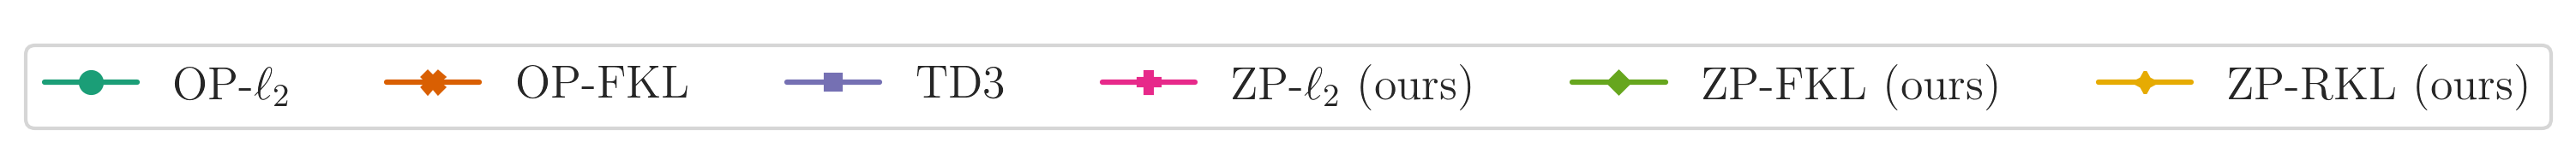

In [19]:
if separate_legend:
    # draw a separate legend figure
    legend_fig, legend_ax = plt.subplots(figsize=(4, 0.1))  # match figsize?
    legend_squared = legend_ax.legend(
        *ans.get_legend_handles_labels(),
        bbox_to_anchor=(0, 0, 2.5, 1),  # x0, y0, width, height
        bbox_transform=legend_fig.transFigure,
        frameon=True,  # controls the border
        fancybox=None,
        shadow=False,
        ncol=len(ans.get_legend_handles_labels()[-1]),  # num of labels
        mode="expand",
    )
    legend_ax.axis("off")
    plt.savefig(
        "plts/" + f"distracted-legend_{metric}_{hue}_{style}.pdf",
        bbox_inches="tight",
        pad_inches=0.03,
    )
    plt.show()
    plt.close()